Loan Payback Analysis
===
We have the loan payback history of some hundred thousands of a bank clients. The loans with payback problem are a few percent of the total number of clients. Those can hence be considered as outliers to main data. We are going to build a model to efficiently detect these outliers.

Libraries
---

In [28]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import time

Data loading and cleaning
---

In [4]:
df = pd.read_csv("loan.csv", nrows=500000, low_memory=False)

In [5]:
cols = df.columns
print ( len(cols) )
#for i in cols :
#    print (i)
    

145


In [6]:
pd.set_option('display.max_columns', None)
df
# There are many categorical and NaN columns

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0,Apr-2001,1,NaN,45.0,9,1,4341,10.3,34,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,Feb-2019,84.92,Mar-2019,Feb-2019,0,NaN,1,Individual,NaN,NaN,NaN,0,0,16901,2,2,1,2,2.0,12560,69.0,2,7,2137,28.0,42000,1,11,2,9,1878.0,34360.0,5.9,0,0,140.0,212,1,1,0,1.0,NaN,2.0,NaN,0,2,5,3,3,16,7,18,5,9,0.0,0,0,3,100.0,0.0,1,0,60124,16901,36500,18124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0,Jun-1987,0,71.0,75.0,13,1,12315,24.2,44,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,Feb-2019,777.23,Mar-2019,Feb-2019,0,NaN,1,Individual,NaN,NaN,NaN,0,1208,321915,4,4,2,3,3.0,87153,88.0,4,5,998,57.0,50800,2,15,2,10,24763.0,13761.0,8.3,0,0,163.0,378,4,3,3,4.0,NaN,4.0,NaN,0,2,4,4,9,27,8,14,4,13,0.0,0,0,6,95.0,0.0,1,0,372872,99468,15000,94072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,490xx,MI,10.51,0,Apr-2011,0,NaN,NaN,8,0,4599,19.1,13,w,4787.21,4787.21,353.89,353.89,212.79,141.10,0.0,0.0,0.0,Feb-2019,180.69,Mar-2019,Feb-2019,0,NaN,1,Individual,NaN,NaN,NaN,0,

In [7]:
len( df.drop_duplicates() )
# no duplicated rows

500000

In [8]:
# Columns with less than 10% NaN values are accepted 
ser = df.isnull().sum() < .1 * len(df)
selCols = ser[ser==True].index
len(selCols)
# 46 columns are dropped

99

In [9]:
pd.set_option('display.max_columns', None)
df2 = df[ selCols ]
df2
# loan_status column contains target classes

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,2500,2500,2500.0,36 months,13.56,84.92,C,C1,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,debt_consolidation,Debt consolidation,109xx,NY,18.24,0,Apr-2001,1,9,1,4341,10.3,34,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,Feb-2019,84.92,Mar-2019,Feb-2019,0,1,Individual,0,0,16901,2,2,1,2,2.0,12560,2,7,2137,28.0,42000,1,11,2,9,1878.0,34360.0,5.9,0,0,140.0,212,1,1,0,1.0,0,2,5,3,3,16,7,18,5,9,0.0,0,0,3,100.0,0.0,1,0,60124,16901,36500,18124,N,Cash,N
1,30000,30000,30000.0,60 months,18.94,777.23,D,D2,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,debt_consolidation,Debt consolidation,713xx,LA,26.52,0,Jun-1987,0,13,1,12315,24.2,44,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,Feb-2019,777.23,Mar-2019,Feb-2019,0,1,Individual,0,1208,321915,4,4,2,3,3.0,87153,4,5,998,57.0,50800,2,15,2,10,24763.0,13761.0,8.3,0,0,163.0,378,4,3,3,4.0,0,2,4,4,9,27,8,14,4,13,0.0,0,0,6,95.0,0.0,1,0,372872,99468,15000,94072,N,Cash,N
2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,debt_consolidation,Debt consolidation,490xx,MI,10.51,0,Apr-2011,0,8,0,4599,19.1,13,w,4787.21,4787.21,353.89,353.89,212.79,141.10,0.0,0.0,0.0,Feb-2019,180.69,Mar-2019,Feb-2019,0,1,Individual,0,0,110299,0,1,0,2,14.0,7150,0,2,0,35.0,24100,1,5,0,4,18383.0,13800.0,0.0,0,0,87.0,92,15,14,2,77.0,0,0,3,3,3,4,6,7,3,8,0.0,0,0,0,100.0,0.0,0,0,136927,11749,13800,10000,N,Cash,N
3,4000,4000,4000.0,36 months,18.94,146.51,D,D2,10+ years,MORTGAGE,92000.0,Source Verified,Dec-2018,Current,n,debt_consolidation,Debt consolidation,985xx,WA,16.74,0,Feb-2006,0,10,0,5468,78.1,13,w,3831.93,3831.93,286.71,286.71,168.07,118.64,0.0,0.0,0.0,Feb-2019,146.51,Mar-2019,Feb-2019,0,1,Individual,0,686,305049,1,5,3,5,5.0,30683,0,0,3761,70.0,7000,2,4,3,5,30505.0,1239.0,75.2,0,0,62.0,154,64,5,3,64.0,0,1,2,1,2,7,2,3,2,10,0.0,0,0,3,100.0,100.0,0,0,385183,36151,5000,44984,N,Cash,N
4,30000,30000,30000.0,60 months,16.14,731.78,C,C4,10+ years,MORTGAGE,57250.0,Not Verified,Dec-2018,Current,n,debt_consolidation,Debt consolidation,212xx,MD,26.35,0,Dec-2000,0,12,0,829,3.6,26,w,29339.02,29339.02,1423.21,1423.21,660.98,762.23,0.0,0.0,0.0,Feb-2019,731.78,Mar-2019,Feb-2019,0,1,Individual,0,0,116007,3,5,3,5,4.0,28845,2,4,516,54.0,23100,1,0,0,9,9667.0,8471.0,8.9,0,0,53.0,216,2,2,2,2.0,0,2,2,3,8,9,6,15,2,12,0.0,0,0,5,92.3,0.0,0,0,157548,29674,9300,32332,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

Regrouping the labels for binary classification
===

In [10]:
df3 = df2.copy()
df3["loan_status"].unique()
# Negatives :
# Loan default occurs when a borrower fails to pay back a debt according to the initial arrangement.
# Late (31-120): Loan has not been current for 31 to 120 days
# Late (16-30): Loan has not been current for 16 to 30 days.
# Charge off is a declaration by a creditor that an amount of debt is unlikely to be collected.

# Positives :
# In Grace Period: Loan is past due but within the 15-day grace period.
# Current : payment is updated
# Fully Paid

array(['Current', 'Fully Paid', 'Late (31-120 days)', 'In Grace Period',
       'Charged Off', 'Late (16-30 days)', 'Default'], dtype=object)

In [11]:
# target is a new column containing the binary classes, 1: payment problem, 0: normal payment
df3["target"] = 1
df3.loc[ df3["loan_status"] == 'In Grace Period', "target" ] = 0
df3.loc[ df3["loan_status"] == 'Current', "target" ] = 0
df3.loc[ df3["loan_status"] == 'Fully Paid', "target" ] = 0

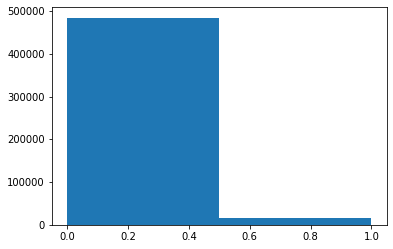

In [12]:
plt.hist(df3["target"], bins=2)
plt.show()
# The class distribution is imbalanced

In [13]:
n1 = len( df3[ df3["target"] == 1 ] )
n0 = len( df3[ df3["target"] == 0 ] )
print( n0, n1, n1/n0 )


484533 15467 0.03192145839395872


3% of the loans contain payment problem. They can be hence assumed as outliers. We try Random Forest estimator with the natural (imbalanced) statistics of the data sample. We then try classification with a resampled set to search for potential detection imporovment. 

In [14]:
# Separating categorical columns
typeData = df3.dtypes
print( typeData )
stringCols = typeData[ typeData=="object" ].index
numCols = typeData[ typeData!="object" ].index
print( len(stringCols) )
stringCols = stringCols.drop( "loan_status" )
stringCols

loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv               float64
term                           object
int_rate                      float64
                               ...   
total_il_high_credit_limit      int64
hardship_flag                  object
disbursement_method            object
debt_settlement_flag           object
target                          int64
Length: 100, dtype: object
22


Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'title',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d',
       'application_type', 'hardship_flag', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')

Onehot encoding the categorical features
===

In [15]:
df4 = df3.drop(columns= ["loan_status"] )
df4 = pd.get_dummies( df4, columns=stringCols, drop_first=True )
len(df4.columns)

1864

Correlations
===
There are 500,000 * 1864 (more than 900 milions) of numbers in the main dataframe. This is rather large for local comutations. We will consider only highly correlated columns with the target classes, those who give ost significant separation between the two classes in the feature space.

In [16]:
corr = []

#for c in numCols :
for c in df4.columns :
    corr.append( df4["target"].corr( df4[ c ] ) )

Corr = pd.DataFrame( zip( df4.columns.tolist(), corr ), columns=["feature", "corr"]  )
Corr["corr"] = Corr["corr"].apply( lambda x : abs(x) )
Corr.sort_values( by="corr", ascending=False, inplace=True )
Corr = Corr.iloc[1:, :]
Corr

,feature,corr
1808,last_pymnt_d_Feb-2019,0.445959
1830,next_pymnt_d_Mar-2019,0.231736
21,recoveries,0.212996
22,collection_recovery_fee,0.209049
1805,last_pymnt_d_Dec-2018,0.188577
...,...,...
471,zip_code_318xx,0.000007
1654,earliest_cr_line_Nov-1981,0.000007
872,zip_code_779xx,0.000007
1311,earliest_cr_line_Feb-1985,0.000006


In [17]:
corrCols = Corr[ Corr["corr"]>.05 ]["feature"]
print( len(corrCols) )
corrCols
# We select those columns with correlation larger than 0.05 with the target classes.

26


1808          last_pymnt_d_Feb-2019
1830          next_pymnt_d_Mar-2019
21                       recoveries
22          collection_recovery_fee
1805          last_pymnt_d_Dec-2018
1822          last_pymnt_d_Nov-2018
1863         debt_settlement_flag_Y
1825          last_pymnt_d_Oct-2018
20               total_rec_late_fee
1827          last_pymnt_d_Sep-2018
1802          last_pymnt_d_Aug-2018
3                          int_rate
1813          last_pymnt_d_Jul-2018
1811          last_pymnt_d_Jan-2019
1861                hardship_flag_Y
1815          last_pymnt_d_Jun-2018
14                        out_prncp
15                    out_prncp_inv
1839    last_credit_pull_d_Feb-2019
146                    pymnt_plan_y
1819          last_pymnt_d_May-2018
81                          grade_D
144                issue_d_Sep-2016
18                  total_rec_prncp
82                          grade_E
8                    inq_last_6mths
Name: feature, dtype: object

Data set preperation
---

In [18]:
# Constructing the label vector
y = df3["target"].values

In [19]:
# Constructing the feature matrix
X = df4[corrCols].values 

In [20]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split( X, y, test_size=.3, random_state=12 )

Random Forest estimator
===

In [32]:
t0 = time.time()
rfc = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_leaf=5)
rfc.fit(Xtrain, Ytrain)
time.time() - t0

33.39798402786255

In [33]:
# training score
rfc.score(Xtrain, Ytrain)

0.9912571428571428

In [34]:
# test score
rfc.score(Xtest, Ytest)

0.99096

In [35]:
def classPredRatio( estimator, X ) : 
    Ypred = estimator.predict( X )
    np0 = len( Ypred[Ypred==0] )
    np1 = len( Ypred[Ypred==1] )
    return np1/np0, Ypred

ratio, Ypred = classPredRatio( rfc, Xtest)
ratio
# The estimator predicts more than 2% of data to be outliers

0.023108613210378413

Confusion matrix
---

In [36]:
# Constructing the confusion matrix

def confusionDF( Y, Ypred ) :
    cm = confusion_matrix(Y, Ypred)
    d = { i : cm[:,i] for i in range( 2 ) }
    index = [ "True_{}".format(i) for i in range( 2 ) ]
    cols = [ "Pred_{}".format(i) for i in range( 2 ) ]
    return pd.DataFrame(d, index=index)

confMatrix = confusionDF( Ytest, Ypred )
confMatrix

,0,1
True_0,145286,30
True_1,1326,3358


Purity computtion
===

In [37]:
# Sample purities
def samplePurity( cm ) :
    print( "0 purity (precision): ", round( cm.iloc[0,0]/(cm.iloc[0,0]+cm.iloc[0,1]), 4 ) )
    print( "1 purity : ", round( cm.iloc[1,1]/(cm.iloc[1,0]+cm.iloc[1,1]), 4 ) )
samplePurity( confMatrix )

0 purity (precision):  0.9998
1 purity :  0.7169


Although the classification score is high but the probability to detect the outliers is about 70%. We are interested in outlier detection so we give them more weights in classification.

Rebalancing the sample
===

In [21]:
dfMaj = df3[ df3["target"]==0 ]
dfMin = df3[ df3["target"]==1 ]

dfMajResam = resample(dfMaj, replace=False, n_samples=len(dfMin), random_state=12) 
dfBalanced = pd.concat( [dfMajResam, dfMin] )
dfBalanced["target"].value_counts()

1    15467
0    15467
Name: target, dtype: int64

In [22]:
# Classifying with a balanced trainig sample
yB = dfBalanced["target"].values
dfB4 = dfBalanced.drop(columns= ["loan_status"] )
dfB4 = pd.get_dummies( dfB4, columns=stringCols, drop_first=True )
XB = dfB4[corrCols].values 
XtrainB, XtestB, YtrainB, YtestB = train_test_split( XB, yB, test_size=.3, random_state=12 )
rfcB = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_leaf=2)
rfcB.fit(XtrainB, YtrainB)
print( " Balanced train set score : ", rfcB.score(XtrainB, YtrainB) )
print( " Balanced test set  score : ", rfcB.score(XtestB, YtestB) )

 Balanced train set score :  0.9776936221308825
 Balanced test set  score :  0.9776963689257623


In [27]:
ratioB, YpredB = classPredRatio( rfcB, XtestB)
ratioB

1.051503094606543

In [28]:
print( " Initail train set score : ", rfcB.score(Xtrain, Ytrain) )
print( " Initial test set score : ", rfcB.score(Xtest, Ytest) )

 Initail train set score :  0.96288
 Initial test set score :  0.96346


In [29]:
ratio2, Ypred2 = classPredRatio( rfcB, Xtest)
ratio2

0.071803702724525

In [30]:
confMatrix2 = confusionDF( Ytest, Ypred2 )
confMatrix2

,0,1
True_0,139893,5423
True_1,58,4626


In [32]:
samplePurity( confMatrix2 )

0 purity (precision):  0.9639
1 purity :  0.9874


Gradient Boosting Tree
===

In [42]:
gbcB = GradientBoostingClassifier()
gbcB.fit( XtrainB, YtrainB )

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [43]:
ratioGbc, YpredGbc = classPredRatio( gbcB, Xtest)
ratioGbc

0.0675016902110095

In [44]:
confMatrixGbc = confusionDF( Ytest, YpredGbc )
confMatrixGbc

,0,1
True_0,140454,4862
True_1,61,4623


In [45]:
samplePurity( confMatrixGbc )

0 purity (precision):  0.9665
1 purity :  0.987


Conclusion
===
We are interested to know how likely a client is to have loan peyment back problem. By making a balanced binary class sample we can detect a payment problem with more than 98.8% confidence.

Comparing the two estimtors
===
We compute the integral of the Reciever Operating Characteristic for Random Forest and Gradient Boosting Tree estimators. This integral shows how good the signal (label=1) is detected.

In [51]:
# Computing the probability for signal detections
yProb = rfcB.predict_proba( X )
y1Prob = [ p[1] for p in yProb ]

yProbGbc = gbcB.predict_proba( X )
y1ProbGbc = [ p[1] for p in yProbGbc ]

In [52]:
# Computing and comparing  the integral for RF and BGT
print( roc_auc_score(y, y1Prob) )
print( roc_auc_score(y, y1ProbGbc) )

0.994071043988305
0.994386804282047
